Author: Jonathan Gong

In [1]:
import pandas as pd
import os
import sys
from sktime.annotation.hmm_learn import GMMHMM 
import numpy as np


# TODO 
- interpolate data so the bgl level readings are recorded at equal time intervals

# Data processing

In [164]:
csv_files = []
for file in os.listdir('../data/raw'):
    if file.endswith('.csv'):
        csv_files.append(pd.read_csv(f'../data/raw/{file}'))

/var/folders/22/0fj82gz10j5cvdcxtqcw5yc80000gn/T/ipykernel_13753/895166927.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_files.append(pd.read_csv(f'../data/raw/{file}'))


In [165]:
each_bgl =[]
for file in csv_files:
    each_df = file[["date", "bgl"]]
    each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
    each_df = each_df.dropna(subset=['date'])
    each_df = each_df.dropna(subset=["bgl"])
    each_df = each_df.sort_values('date')
    each_df = each_df.drop_duplicates(subset=['date'])
    print(type(each_df))
    each_df.set_index('date', inplace=True)
    each_bgl.append(each_df)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


/var/folders/22/0fj82gz10j5cvdcxtqcw5yc80000gn/T/ipykernel_13753/2409137033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
/var/folders/22/0fj82gz10j5cvdcxtqcw5yc80000gn/T/ipykernel_13753/2409137033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)


In [166]:
np.unique(each_bgl[0])

array([ 39.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,
        64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,
        75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,
        86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,
        97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
       108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118.,
       119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
       130., 131., 132., 133., 134., 135., 136., 137., 138., 139., 140.,
       141., 142., 143., 144., 145., 146., 147., 148., 149., 150., 151.,
       152., 153., 154., 155., 156., 157., 158., 159., 160., 161., 162.,
       163., 164., 165., 166., 167., 168., 169., 170., 171., 172., 173.,
       174., 175., 176., 177., 178., 179., 180., 181., 182., 183., 184.,
       185., 186., 187., 188., 189., 190., 191., 19

In [42]:
# days_patients = []
# for bgl in each_bgl:
#     # (hour:minute:second)
#     bgl['time'] = bgl['date'].dt.time
#     # (year-month-day)
#     bgl['day'] = bgl['date'].dt.date
#     # unique days
#     unique_days = bgl['day'].unique()
#     day_data = []
#     for i, day in enumerate(unique_days):
#         bgl_day = bgl[bgl['day'] == day]
#         day_data.append(bgl_day["bgl"])

#     days_patients.append(day_data)

In [43]:
sequences = df_resampled_1["bgl"].to_numpy()
sequences = sequences.reshape(-1, 1)

In [44]:
len(sequences)

26496

In [45]:
justnorm_sequences = sequences/max(sequences)

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(each_bgl[0])

In [201]:
from sklearn.cluster import KMeans
data_used = each_bgl[0][3500:4000]
n_components = 2 # Number of components in the GMMHMM
kmeans = KMeans(n_clusters=n_components).fit(data_used)
initial_means = kmeans.cluster_centers_

In [115]:
initial_means

array([[113.27272727],
       [ 96.47368421]])

# Model training and eval

In [202]:
n_components = 2
model = GMMHMM(n_components=n_components, n_mix = 2, covariance_type = 'full', n_iter = 100, verbose=True)
model.startprob_ = np.array([0.5, 0.5])
model.means_ = initial_means
model.fit(data_used)

         1   -2524.08505622             +nan
         2   -2468.64703189     +55.43802433
         3   -2475.35984899      -6.71281710
Model is not converging.  Current: -2475.359848988479 is not greater than -2468.647031889409. Delta is -6.71281709906998


GMMHMM(covariance_type='full', n_components=2, n_iter=100, n_mix=2,
       verbose=True)

In [203]:
hidden_states = model.predict(data_used)

In [204]:
np.unique(hidden_states) #im gna kill myself please for the love of god be smth different

array([1])

In [ ]:
len(hidden_states)

39518

In [ ]:
hidden_states

array([0, 0, 0, ..., 0, 0, 0])

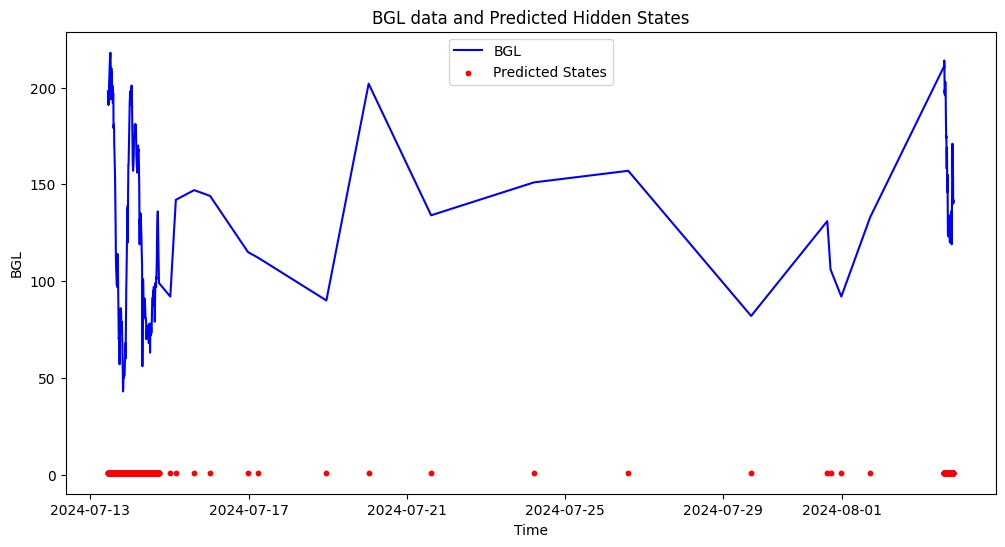

In [205]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 6))
plt.plot(data_used.index, data_used["bgl"], label='BGL', color='blue')
plt.scatter(data_used.index, hidden_states, c='red', label='Predicted States', s=10)
plt.title("BGL data and Predicted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()